# Riemann Solvers

Advection is a central property of all Eulerian numerical schemes. E.g. methods where quantities are described by a fixed grid, but material is being transported, and evolves, in the background grid. In this exercise we will generalise this setup from advection to hydrodynamics.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Hydrodynamics
The equations of hydrodynamics are
\begin{align}
\partial_t \rho + \mathbf{\nabla} \cdot [\rho\,\mathbf{v}] & = 0 \\
\partial_t \rho\,\mathbf{v} + \mathbf{\nabla} \cdot [\rho\, \mathbf{v}\otimes\mathbf{v} + P \,\mathsf{I}] & = 0 \\
\partial_t E + \mathbf{\nabla} \cdot [(E + P)\, \mathbf{v}] & = 0\,,
\end{align}
where $\rho$ is density, $\mathbf{v}$ is velocity, $P$ is pressure, and $E$ is the total energy density. $E = \rho e + {1 \over 2} \rho v^2$, and $e$ is the internal energy per mass. This is complemented by an equation of state $P = (\gamma - 1)\rho e$. $\mathsf{I}$ is the identity matrix, so that $\mathbf{\nabla} \cdot [P\,\mathsf{I}] = \mathbf{\nabla}P$.

This can also be written in the Lagranian form
\begin{align}
\partial_t \rho & = - \mathbf{v} \cdot \mathbf{\nabla} \rho
- \rho \mathbf{\nabla} \cdot \mathbf{v} \\
\partial_t \mathbf{v} & = - (\mathbf{v} \cdot \mathbf{\nabla}) \mathbf{v}
- \frac{1}{\rho} \mathbf{\nabla} P  \\
\partial_t P &= - \mathbf{v} \cdot \mathbf{\nabla} P
- \gamma P \mathbf{\nabla} \cdot \mathbf{v}\,,
\end{align}
where the advective derivative ($-\mathbf{v} \cdot \mathbf{\nabla}$) is explicit.

In the special case where the temperature is constant the equations simplify to
\begin{align}
\partial_t \rho + \mathbf{\nabla} \cdot [\rho\,\mathbf{v}] & = 0 \\
\partial_t \rho\,\mathbf{v} + \mathbf{\nabla} \cdot [\rho\, \mathbf{v}\otimes\mathbf{v} + P \,\mathsf{I}] & = 0
\end{align}
and $P = c_s^2 \rho$, where $c_s^2 = k_b T / \mu m_p$ is the isothermal sound speed. To keep it simlpe, we will start by considering isothermal hydrodynamics. You will the yourselves add the energy equation.

### MUSCL Method for time updates
To simplfy the equations we will write the system in vector notation with a _state vector_ $U$, and a _flux vector_ $F$, and assume we have one dimension. Then
\begin{align}
U &= (\rho, \rho u) \\
F &= (\rho u, \rho u u + P) \\
\partial_t U + \partial_x F &= 0
\end{align}

The __master equation__ for solving the system:
\begin{equation}
U(t + \Delta t,x_{i-1/2}) - U(t,x_{i-1/2}) = \frac{\Delta t}{\Delta x} \left[ \tilde F(t + {\Delta t \over 2},x_{i-1}) - \tilde F(t + {\Delta t \over 2},x_{i}) \right]\,,
\end{equation}
where the flux terms are integrals over the time step and the cell faces (that in 1D is just a point, but in 2D a line, and in 3D an area)
\begin{equation}
\tilde F(t + {\Delta t \over 2},x_{i}) = {1 \over \Delta t}
\int^{t + \Delta t}_t \textrm{d} t' F(t', U_I(t',x_i))\,,
\end{equation}
and $U_I$ are the point values of $U$ at the interface.

The MUSCL method improves on Godunov method by approximating the time integral and assuming that we can make a slope interpolation for the values at the interface.
The alogrithm goes as follows
  1. From the state vector $U$ compute the _primitive_ variables q = ($\rho$,$v$,$P$)
  2. Compute the spatial slopes from the center of the cell to the interface. Making the slopes monotonized (TVD) if needed. The slope accross a cell are $\Delta q_x$.
  3. Compute a naive time evolution for the primitve variables at the center of the cell using an Euler step and the Lagranian hydro equations. E.g.
\begin{equation}
\Delta q_t = \Delta t \frac{\textrm{d}q}{\textrm{d}t}
\end{equation}
  4. Approximate $q(t+\Delta t/2, x\pm\Delta x/2) = q(t,x) + (\Delta q_t \pm \Delta q_x) / 2$
  5. Shift point of view from cells to interfaces and consider fluid variables on the _left_ and _right_ sides of _interfaces_.
  6. Assume that the fluid variables are constant on each side of the cell interface, and use an (approximate) Riemann solver to compute the fluxes.

Here is the code corresponding to the algorithm. Notice how we use a _class_ to contain the experiment data and related functions, and help in readability. This makes it easy to extend the code with different variables and functions, if needed.

### Coordinates
Defining a coordinate vector may seem trivial, but it is important always to have a clear picture of _where_ different cell center and interface values are placed in memory. We have decided to use a so-called up-staggered coordinate system, because the interface to the right (or _up_) is placed in memory at the same position as the cell center values. We could as well have used a down-staggered coordinate system. It is a choice of convention.

In [3]:
# Define a coordinate vector with coordinates at the midpoint of the cells.
# Domain is 2pi in length and there are n cells.
#
# inter          inter
# face   center  face
#  |-------o-------|-------o-------|-------o-------|--- ... ----o----|
# x=0    x=ds/2   x=ds  x=3/2ds  x=2ds  x=5/2ds  x=3ds  ...         x=2pi
# x_0    x_1/2    x_1    x_3/2    x_2    x_5/2    x_3   ... x_n-1/2  x_n
# Python array position for cell quantities
#          0               1               2            ...    n-1
#
# Python array position for interface quantities
# n-1              0               1               2    ...          n-1
#
def coordinates(n, Lbox=2.0*np.pi):
    ds=Lbox/n
    # Two ways of accomplishing the same thing, either with arange or linspace
    # x = np.linspace(0., Lbox, num=n, endpoint=False)+0.5*ds
    x = ds*(np.arange(n) + 0.5)
    return ds,x

### Derivatives and slope limiters

In [4]:
# Compute a "left slope". Returns the slope at the cell interface between x_i-1/2 and x_i+1/2
# at the index position i. Left slope is useful for computing slopes
def left_slope(f,axis=0):
    return (f-np.roll(f,1,axis))

# Slopes are calculated at the grid center position
# Four slopes are given:
#   no_slope, Cen, MinMod, MonCen
#############################################################
# no_slope is zero everywhere producing the Upwind method
def no_slope(f):
    return np.zeros_like(f)

# Centered derivative; e.g. no slope limiter. This is unstable!
def Cen(f):
    ls = left_slope(f) # left slope
    rs=np.roll(ls,-1)  # roll down once (giving the slope to the right)
    return 0.5*(ls+rs) # the average of the left and right slopes is simply the centered derivative (deriv(f))

# MinMod slope limiter
def MinMod(f):
    ls = left_slope(f)                      # left slope
    rs = np.roll(ls,-1)                     # right slope
    sign = np.ones(ls.shape)                # start with making sign equal +1
    sign[np.where(ls < 0.0)] -= 1.0         # where left slope is negative, make sign 0
    sign[np.where(rs < 0.0)] -= 1.0         # if left *and* right slope are negative, sign is -1, if only right slope is negative, sign is 0
    return np.minimum(abs(ls),abs(rs))*sign # return the smallest size of the two slopes with correct sign, but zero if they disagree about sign

# MonCen slope limiter
def MonCen(f):
    ls = left_slope(f)                      # left slope
    rs = np.roll(ls,-1)                     # right slope
    cs = np.zeros_like(ls)                  # MonCen starts out as zero slope
    w  = np.where(ls*rs>0.0)                # Where both slopes agree in sign, we compute it
    cs[w]=2.0*ls[w]*rs[w]/(ls[w]+rs[w])     # MonCen slope is the harmonic average of the left and right state
    return cs

### Hydro data and auxiliary conversion methods from conservative to primitive variables
We will use a class to encapsulate all the functions we need to manipulate basic variables. Remember from exercise __1a__ how a class can contain both variables and functions, and that the first argument to a function always is the class itself. There is also a special class function "\_\_init\_\_" that populates the initial data for the class

In [5]:
# Define an hydro state including all auxiliary scalars and coordinates in a class
class hd():
    def __init__(self,n,gamma=1.,cs=1.,Lbox=2.0*np.pi):
        dx, x = coordinates(n, Lbox=Lbox)
        self.n = n                             # number of points
        self.dx = dx                           # cell size
        self.Lbox = Lbox                       # Box size
        self.x = x                             # coordinate axis
        self.gamma = gamma                     # adiabatic index
        self.cs = cs                           # initial sound speed, if isothermal it is fixed
        self.t = 0.                            # time
        self.rho = np.ones(n)                  # density  
        self.Px  = np.zeros(n)                 # momentum density = rho*velocity_x
        if gamma != 1.0:                       # non-isothermal
            Pressure = cs**2*self.rho / gamma
            Eint = Pressure / (self.gamma - 1.)
            self.Etot = Eint   # total energy

    # Compute velocity from state vector
    def velocity(self):
        """ Compute velocity from conservative variables """
        return self.Px / self.rho

    # Compute pressure from state vector
    def pressure(self):
        """ Compute pressure from conservative variables """
        if self.gamma==1.0:
            P = self.cs**2 * self.rho
        else:
            Eint = self.Etot - 0.5 * self.Px**2 / self.rho # Internal energy
            P = (self.gamma-1.)*Eint
        return P

    # compute sound speed
    def sound_speed(self):
        """ Sound speed for HD """
        # if gamma=1 gas is isothermal, and sound speed is a property of the equation of state
        if (self.gamma==1.):
            return self.cs
        else:
            P = self.pressure()
            cs = np.sqrt(self.gamma*P/self.rho)
            return cs

    # Courant condition with default Courant number=0.2 for a fluid
    # maximum propagation velocity is max(|v| + sound speed), where max is taken over all cells
    def Courant(self,Cdt=0.2):
        """ Courant condition for HD """
        speed = abs(self.velocity())
        dt = Cdt * self.dx / np.max(speed + self.sound_speed())
        return dt

### Riemann Solvers
First set up a two trivial functions for converting between the primitive variables $q = (\rho, v, P)$ and conservative variables $U=(\rho,\rho v, E)$, where $E$ is the total energy, and for computing the corresponding hydrodynamical flux vector. Then use those to make two example approximate Rieman solvers _LLF_ and _HLL_ that compute the flux at an interface given a left and right state.

In [6]:
# encodes a state vector -- either of variables or a flux
# initialize it as an empty class
class void():
    """ Empty class, used to create ad hoc objects """
    pass

# Conservative variables computed from primitve variable
def primitive_to_conservative(q):
    U = void()
    U.D  = q.D
    U.mU = q.D*q.U
    return U

# Hydro flux from conservative and primitive variables
def Hydro_Flux(q,U):
    F = void()
    F.D  = U.mU
    F.mU = U.mU * q.U + q.P
    return F

In [7]:
# LLF is the most diffuse Riemann solver. But also the most stable.
# ql = (density, velocity, pressure) = (D, U, P), qr are state vectors for the _primitive_ variables 
def LLF(ql,qr):
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P / ql.D)**0.5
    c_right = (qr.gamma*qr.P / qr.D)**0.5
    c_max = np.maximum(c_left,c_right)
    
    # maximum absolute wave speed for left and right state
    cmax = np.maximum(np.abs(ql.U)+c_max,np.abs(qr.U)+c_max)
    
    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)

    # LLF flux based on maximum wavespeed.
    # The general form is "(F_left + F_right - cmax*(U_right - U_left)) / 2"
    # where U is the state vector of the conserved variables
    Flux = void()
    Flux.D  = 0.5*(Fl.D  + Fr.D  - cmax*(Ur.D  - Ul.D))
    Flux.mU = 0.5*(Fl.mU + Fr.mU - cmax*(Ur.mU - Ul.mU))
    # Flux.Etot = ...
    
    return Flux

# HLL (Harten, Lax, van Leer) is a bit less diffuse. We compute individual wave speeds for each state
# ql, qr are state vectors for the _primitive_ variables 
def HLL(ql,qr):
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P / ql.D)**0.5
    c_right = (qr.gamma*qr.P / qr.D)**0.5
    c_max = np.maximum(c_left,c_right)
    
    # maximum wave speeds to the left and right (guaranteed to have right sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.

    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)

    # HLL flux based on wavespeeds. If SL < 0 and SR > 0 then mix state appropriately
    # The general form is
    #    (SR * F_left - SL * F_right + SL * SR *(U_right - U_left)) / (SR - SL)
    # where U is the state vector of the conserved variables
    Flux = void()
    Flux.D  = (SR*Fl.D  - SL*Fr.D  + SL*SR*(Ur.D  - Ul.D )) / (SR - SL)
    Flux.mU = (SR*Fl.mU - SL*Fr.mU + SL*SR*(Ur.mU - Ul.mU)) / (SR - SL)
    #Flux.Etot = 

    return Flux

### MUSCL time update algorithm

In [8]:
# Hydrodynamics solver based on MUSCL scheme
def muscl(u,dt,Slope=MinMod,Riemann_Solver=HLL):
    dx = u.dx
    idx = 1. / u.dx
    dtdx = dt / u.dx

    # 1) Compute primitive variables at cell center (rho, v, P)
    rho = u.rho
    v   = u.velocity()
    P   = u.pressure()

    # 2) Compute slope limited derivatives based on centered points
    drhodx = Slope(rho) * idx
    dvdx   = Slope(v) * idx
    dPdx   = Slope(P) * idx

    # 3) Trace forward to find solution at [t+dt/2, x +- dx/2]
    # Time evolution for source terms
    rho_t = - v * drhodx - dvdx * rho
    v_t   = - v * dvdx - dPdx / rho
    # Here we need to compute time evolution for P
    
    # Spatial interpolation + time terms
    # left state at t + dt/2 -- AS SEEN FROM THE INTERFACE
    ql = void()
    ql.gamma = u.gamma
    ql.D = rho + 0.5 * (dt*rho_t + dx*drhodx)
    ql.U = v   + 0.5 * (dt*v_t   + dx*dvdx)
    if u.gamma==1:
        ql.P = u.cs**2 * ql.D
    else:
        print("ql.P should not be computed but instead reconstructed like the rest if not isothermal")
    
    # Spatial interpolation + time terms
    # right state at t + dt/2 -- AS SEEN FROM THE INTERFACE
    qr = void()
    qr.gamma = u.gamma
    qr.D = rho + 0.5 * (dt*rho_t - dx*drhodx)
    qr.U = v   + 0.5 * (dt*v_t   - dx*dvdx)
    if u.gamma==1:
        qr.P = u.cs**2 * qr.D
    else:
        print("qr.P should not be computed but instead reconstructed like the rest if not isothermal")

    # make sure that right state is centered correctly.
    # Numerical index follow upstaggered interfaces,
    qr.D = np.roll(qr.D,-1)
    qr.U = np.roll(qr.U,-1)
    qr.P = np.roll(qr.P,-1)

    # 4) Solve for flux based on interface values
    Flux = Riemann_Solver(ql,qr)
    
    # 5) Update conserved variables.
    #    From the cell center (at x_i) point of view:
    #       * 1st term is the upstaggered value at the interface position x_i + dx/2
    #       * 2nd term is the downstaggered value at the interface position x_i - dx/2. Therefore we roll.
    u.rho += - dtdx * (Flux.D  - np.roll(Flux.D,1))
    u.Px  += - dtdx * (Flux.mU - np.roll(Flux.mU,1))
    # Update energy flux ...
    
    return u

### Initial condition
Setup an initial condition for a sound wave traveling to the right

In [9]:
# returns a simple Sine wave traveling at velocity v evaluated at time t
def wave(x,v,t):
    f=np.sin(x-v*t)
    return f

def initial_condition(u,eps=0.01,rho0=1.):
        velocity = eps*u.cs*wave(u.x,0.,0.)     # velocity
        u.rho = rho0*(1. + eps*wave(u.x,0.,0.)) # density for a sound wave with relative amplitude "eps"
        u.Px = rho0*velocity                    # momentum density
        # check if not an isothermal setup, and then compute the total energy
        if u.gamma != 1.:
            P = u.cs**2 * u.rho / u.gamma
            Eint = P / (u.gamma - 1.)
            u.Etot = Eint + 0.5 * u.px**2 / u.rho


### Time Evolution Loop

In [10]:
# setup graphics
def wide_fig(title='',s=''):
    if title=='':
        title='{}  Courant={:.2f}'.format(s,C)
    plt.figure(figsize=(14,4))
    plt.title(title);

Number of iterations : 324
Time                 : 6.283185307179586
Resolution           : 64
Periods advected     : 1.0


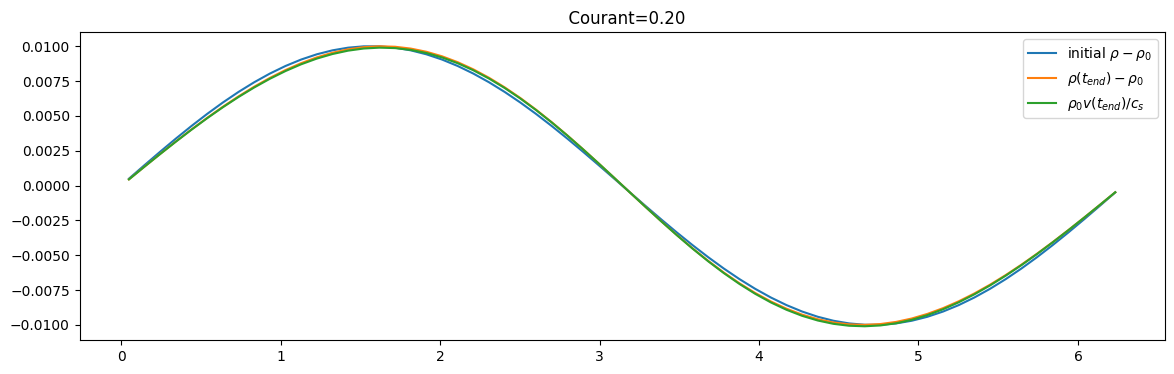

In [11]:
n = 64         # number of grid points
C = 0.2        # Courant number (<0.5 for stability)
rho0 = 1.      # Average density
gamma = 1.     # Adiabatic index
cs  = 1.       # Sound speed
eps = 0.01     # relative amplitude of soundwave
Slope=Cen   # choose a slope
Riemann_Solver=LLF # choose a Riemann solver

# set up exepriment with a soundwave initial condition
u = hd(n,gamma=1.,cs=cs)
initial_condition(u,eps=eps,rho0=rho0)

periods = 1.0  # number of periods to advect
tend = periods*u.Lbox / u.cs # corresponding end time if wave moves with sound speed (cs)

# caluclate an approximate guess for the
# number of iterations needed
# dt ~ C * dx / cs, since cs is the soundspeed
# 1.5 is a safety factor, given that the phase
# velocity of the wave may limit the time step a bit
nt = int(1.5 * tend / (C * u.dx / cs))

wide_fig()
plt.plot(u.x,u.rho - rho0,'-',label=r'initial $\rho-\rho_0$')

it = 0
while(u.t < tend and it < nt):
    dt=u.Courant(C) # get size of dt
    if (u.t+dt > tend): # make sure we arrive at tend exactly
        dt = tend - u.t

    u = muscl(u,dt,Slope=Slope,Riemann_Solver=Riemann_Solver) # Evolve solution by dt
    # increment time and iteration count
    u.t += dt 
    it += 1

# Plot the final density in orange
plt.plot(u.x,u.rho-rho0,'-',label=r'$\rho(t_{end}) - \rho_0$')

# Plot the corresponding velocity. Rescale with a factor of rho0 / u["cs"] to make
# it same amplitude as density (can be seen by e.g. dimensional analysis)
plt.plot(u.x,rho0*u.velocity()/u.cs,'-',label=r'$\rho_0 v(t_{end}) / c_s$')


plt.legend();

print("Number of iterations :", it)
print("Time                 :", u.t)
print("Resolution           :", u.n)
print("Periods advected     :", periods)
if (u.t < tend):
    print("OBS hit maximum number of iterations, something may be broken.")
    print("nt   =", nt)
    print("t    =", u.t)
    print("tend =", tend)

In the plot above we have three quantities:
  * Blue: the initial density perturbation (the average density $\rho_0$ has been subtracted)
  * Orange: the final density perturbation
  * The velocity perturbation rescaled to units of density by dividing with sound speed and multiplying the average density (why is this a good rescaling :-? )

### Tasks:

In this exercise the learning objective is to understand the different steps in the MUSCL algorithm. We will use a simple sound wave as our setup, but the solver is general. Any other initial condition would work, such as a shock, as long as it is periodic. You are welcome to construct your own initial condition, and see what happens!

To aid in understanding how it works you will
  - extend the solver to include the total energy
  - _experimentally_ test how well the sound speed is conserved (how will you do that?)
  - relate to the physical problem of a hydrodynamical wave, by changing the parameters

The tasks are:
  1. Execute the notebook. Make a routine to measure the sound speed.
  2. Extend the algorithm to include the energy equation. What is the sound speed now; discuss why?
  3. Change the amplitude to something larger. What happens; discuss why?